<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/open_cv_remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageChops,ImageOps
import time


def sort_imgs(imgs:list):
  new_imgs = []
  narray = np.arange(0,len(imgs))
  for i in range(len(imgs)):
    rate = imgs[i].size[0] / imgs[i].size[1]
    result = False if 0.8 < rate < 1.2 else True
    print(i,result,imgs[i].size,rate)
    if result:break
    narray = np.roll(narray,-1)
    print(narray)
  new_imgs = [imgs[i] for i in narray]
  return new_imgs

# # # # # #
# Pillow  #
# # # # # #

def crop_image(path:str)->Image:
  image = Image.open(path)
  # getpixel(0, 0) で左上の色を取得し、背景色のみの画像を作成する
  bgc = image.getpixel((0, 0))
  print('bgc',bgc)
  bg = Image.new(image.mode, image.size,bgc)

  fix_image = ImageOps.autocontrast(image,0.5)
  # 背景色画像と元画像の差分を取得
  diff = ImageChops.difference(fix_image, bg)
  diff = ImageChops.add(diff, diff, 2.0, -100)
  # 黒背景の境界Boxを取り出す
  bbox = diff.getbbox()
  # 元画像を切り出す
  cropped = image.crop(bbox)
  cropped.save('cropped_edge.jpg')
  cropped = image.crop(bbox)
  return cropped


def triple_images(imgs,size):
  x,y,x1,y1 = 0,0,0,0

  # image 1
  imgs[0].thumbnail((img_size,img_size))
  print('imgs[0].size',imgs[0].size)

  space_x = img_size - imgs[0].size[0]
  if space_x == 0:
    space_x = img_size
    space_y = img_size - imgs[0].size[1]
  else:
    space_x = img_size - imgs[0].size[0]
    space_y = img_size
  print('space_x',space_x)
  print('space_y',space_y)
  imgs[1].thumbnail((space_x,space_y))

  if imgs[0].size[0] != img_size: x1 = imgs[0].size[0] 
  if imgs[0].size[1] != img_size: y1 = imgs[0].size[1] 
  print('x1,y1',x1,y1)

  # image 2
  print('imgs[1].size',imgs[1].size)
  x2,y2 = x1,y1
  if x1 == 0: x2 = imgs[1].size[0]
  if y1 == 0: y2 = imgs[1].size[1]
  print('2:x,y',x,y)

  sx = img_size - x2
  sy = img_size - y2
  print('xs,xy',sx,sy)

  imgs[2].thumbnail((sx,sy))

  # make background
  bgc = imgs[0].getpixel((imgs[0].size[0]-1,imgs[0].size[1]-1))
  bg = Image.new('RGB',(img_size,img_size),bgc)

  xm,ym = 0,0
  if imgs[0].size[0] == img_size: 
    xm = size - imgs[1].size[0] - imgs[2].size[0] 
    xm = int(xm/2)
  if imgs[0].size[1] == img_size: 
    ym = size - imgs[1].size[1] - imgs[2].size[1] 
    ym = int(ym/2)
  print('xm,ym',xm,ym)

  bg.paste(imgs[0],(x,y)  ) # image 1
  bg.paste(imgs[1],(xm + x1,ym + y1)) # image 2
  bg.paste(imgs[2],(xm + x2,ym + y2)) # image 3

  return bg

bgc (255, 255, 255)
bgc (234, 232, 233)
bgc (230, 228, 229)
bgc (235, 235, 235)
0 True (1538, 964) 1.595435684647303
imgs[0].size (500, 313)
space_x 500
space_y 187
x1,y1 0 313
imgs[1].size (369, 187)
2:x,y 0 0
xs,xy 131 187
xm,ym 0 0
2.136802911758423


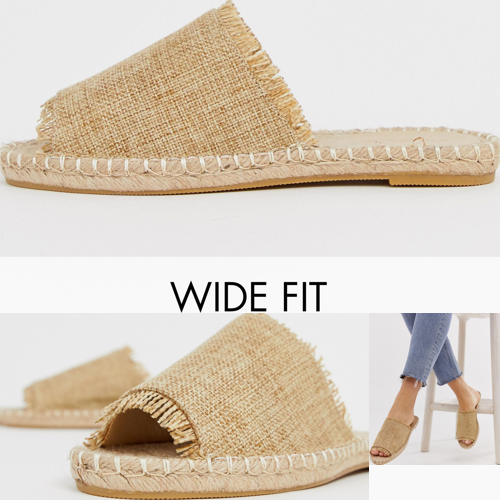

In [39]:

img_paths = ['/content/12030065/a03.jpg','/content/12030065/a02.jpg','/content/12030065/a01.jpg']
img_paths = ['/content/8934106/a02.jpg','/content/8934106/a01.jpg','/content/8934106/a03.jpg']
img_paths = ['/content/11004955/a04.jpg','/content/11004955/a02.jpg','/content/11004955/a03.jpg']
img_paths = ['/content/11006540/a03.jpg','/content/11006540/a02.jpg','/content/11006540/a01.jpg']
img_paths = ['/content/11004770/a01.jpg','/content/11004770/a04.jpg','/content/11004770/a03.jpg']
img_paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a04.jpg']
img_paths = ['/content/10990068/a01.jpg','/content/10990068/a02.jpg','/content/10990068/a03.jpg','/content/10990068/a04.jpg']
start = time.time()
imgs = [crop_image(path) for path in img_paths]
imgs = sort_imgs(imgs)
img_size = 500
new_image = triple_images(imgs,img_size)
print(time.time() - start)
new_image

In [0]:

sort_img(imgs)
imgs[0]

In [0]:
!unzip small_sample.zip
!unzip shoes_sample.zip
!unzip middle_sample.zip